In [ ]:
#hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#default_exp data

## Index of each labelling method

In [ ]:
# export
index_cols = {
    "fli": 4,
    "fli_no_uncertainty": 5,
    "freq_ana_eq_3.5": 6,
    "freq_ana_eq_3.6": 7,
    "birav": 8,
    "birav_refined": 9,
    "combined": list(range(4,9)) # Exclude the birav refined from the combined since it has different classes
}

# Data

> Methods to load time series data from motion files

In [ ]:
#export
from mlchaos.imports import * 
from fastcore.all import *
from timeseries.all import *
from tsai.imports import *
import pandas as pd
import numpy as np
from mlchaos.utils import df_slicer
from plotnine import *

In [ ]:
base_path = Path.home()

## Motions defined in files Poincare.plt and index.plt

We call an `item` as a pair `(fname_poincare, fname_index)`. From the Poincare file we get the data of the time series (the x or independent variable) and from the index file we get the y or dependent variable

### Load motion data from poincare file (independent variables)

In [ ]:
#export
def load_poincare_maps(fname:Path):
    "Load the data from a Poincare map.\
    Returns a numpy array with a shape (n_orbits, 2, sequence_length). \
    The time column is removed from the data, since it is always multiples of 2*pi"
    df = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])
    seq_length = set(df.time).__len__()
    df = df.drop('time', axis=1)
    nparr = df_slicer(df, w=seq_length, s=seq_length)
    return nparr.transpose([0, 2, 1])

In [ ]:
fname = Path('../example_data/Poincare.plt')
foo = load_poincare_maps(fname)
bar = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])

In [ ]:
seq_len = set(bar.time).__len__()
test_eq(foo.shape[2], seq_len)

In [ ]:
test_eq(foo.shape[0], bar.shape[0]/seq_len)

In [ ]:
test_eq(foo[0,:,:], bar.drop('time', axis=1)[:seq_len].values.transpose(1,0))

### Load index of the motion from index file (dependent variable)

In [ ]:
#export
def load_index_file(fname:Path, index_col=7, multiindex_handler=None, uncertainty_index=-1.):
    r"""
    Returns the index of an index file. In case the argument `index_col` has 
    more than one value (i.e., it's a list), the argument `multiindex_handler`
    will indicate what to do. Possible values are:
        * None: Do nothing
        * 'uncertainty': Set the value `uncertainty_index` as index of that row
        * 'random': Randomly sample one index from the multiple options.
    """
    indices = pd.read_table(fname,
                         sep='\s+',
                         header=None,
                         usecols=L(index_col),
                         squeeze=True).values
    # indices is a numpy array
    if len(indices.shape) > 1:
        if multiindex_handler == 'uncertainty':
            indices = array([x[0] if np.all(x == x[0]) else uncertainty_index 
                             for x in indices])
        elif multiindex_handler == 'random':
            # Randomly choose one index for each row
            idx_msk = np.random.choice(indices.shape[1], indices.shape[0])
            indices = np.choose(idx_msk, indices.T)
    return indices

In [ ]:
fname = Path('../example_data/index.plt')

In [ ]:
foo = load_index_file(fname)
test_eq(foo.__class__, np.ndarray)
test_eq(foo.ndim, 1)

Test different multi index handlers

In [ ]:
foo = load_index_file(fname, index_col=[7,8]) # None
bar = load_index_file(fname, index_col=[7,8], multiindex_handler='uncertainty')
baz = load_index_file(fname, index_col=[7,8], multiindex_handler='random')
test_eq(foo.ndim, 2)
test_eq(bar.ndim, 1)
test_eq(baz.ndim, 1)

### Load x and y at once from both the Poincare and the index file

In [ ]:
#export
@delegates(to=load_index_file, but=['fname'])
def load_poincare_index_pair(fname_poincare:Path, fname_index:Path, index_col=7, **kwargs):
    "Load the x data from a Poincare file and the y data from the index file.\
    If multiple indices are used form the indices file, each sample of the poincare file \
    is replicated once for every possible index associated to every motion. \
    Returns a tuple of 2 numpy arrays: "
    "x : array with a shape (n_samples, n_channels, sequence_length)"
    "y : array with a shape (n_samples)"
    "for the Poincare maps, n_channels is 2 (x and y)"
    x = load_poincare_maps(fname_poincare)
    y = load_index_file(fname_index, index_col=index_col, **kwargs)
    if y.ndim > 1:
        # Replicate each sample for each index value and assign one index to each replica
        x = x.repeat(y.shape[1], axis=0)
        y = y.flatten()
    return (x, y)

In [ ]:
fname_poincare = Path('../example_data/Poincare.plt')
fname_index = Path('../example_data/index.plt')

In [ ]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index)
test_eq(foo.__class__, np.ndarray)
test_eq(bar.__class__, np.ndarray)
test_eq(len(foo), len(bar))

In [ ]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index, index_col=[7,8])
test_eq(len(foo), len(bar))
test_eq(bar.ndim, 1)

### Create TSData object from a list of (Poincare.plt, index.plt) files

In [ ]:
#export
class TSDataChaos(TSData):
    @classmethod
    @delegates(to=load_poincare_index_pair)
    def from_poincare_and_index_files(cls, fnames, index_col=7, **kwargs):
        "`fnames` is a list of pairs (poincare_file, index_file), or a single pair."
        self = cls(fnames)
        self.x = []
        self.y = []
        self.dsname = []
        self.fnames = []
        self.ds = []
        self.index_col = index_col
        xs,ys, dss = [],[],[]
        if isinstance(fnames, L) or isinstance(fnames, list):
            for i, (fn_poincare, fn_index) in enumerate(fnames):
                fn_poincare, fn_index = Path(fn_poincare), Path(fn_index)
                dsname = fn_poincare.parent.name
                x, y = load_poincare_index_pair(fn_poincare, fn_index, index_col, **kwargs)
                xs.append(x)
                ys.append(y)
                dss.append(np.repeat(i, len(y))) # Map each item with the dataset it belongs to
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(dsname)
            self.x = np.concatenate(xs)
            self.y = np.concatenate(ys)
            self.ds = np.concatenate(dss).squeeze()
        else:
            fn_poincare, fn_index = Path(fnames[0]), Path(fnames[1])
            dsname = fn_poincare.parent.name
            self.fnames.append(fnames)
            self.dsname.append(dsname)
            self.x, self.y = load_poincare_index_pair(fn_poincare, fn_index, 
                                                      index_col=index_col, **kwargs)
            self.ds = np.repeat(0, len(self.y))
        return self

    @classmethod
    def from_poincare_maps(cls, fnames):
        "`fnames` is a list of paths to Poincare maps. No ys are provided"
        self = cls(fnames)
        self.x = []
        self.y = None
        self.dsname = []
        self.fnames = []
        xs = []
        if isinstance(fnames, list):
            for fn_poincare in fnames:
                x = load_poincare_maps(fn_poincare)
                xs.append(x)
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(fn_poincare.parent.name)
            self.x = np.concatenate(xs)
        else:
            fn_poincare = fnames
            self.fnames.append(fn_poincare)
            self.dsname.append(fn_poincare.parent.name)
            self.x = load_poincare_maps(fn_poincare)
        return self
    
    @classmethod
    def from_xy(cls, x:np.ndarray, y:np.ndarray, index_col):
        "`x` and `y` are numpy arrays"
        self= cls([])
        self.x = x
        self.y = y
        self.dsname = []
        self.fnames = []
        self.index_col = index_col
        return self

In [ ]:
fnames = (Path('../example_data/Poincare.plt'), 
            Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames, index_col=5)
foo

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [ ]:
test_eq(foo.__class__, TSDataChaos)

In [ ]:
bar = TSDataChaos.from_poincare_and_index_files(fnames, index_col=8)
bar

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [ ]:
x0, y0 = foo.x[0], foo.y[0]
y0

1.0

In [ ]:
test_ne(foo.y, bar.y) 

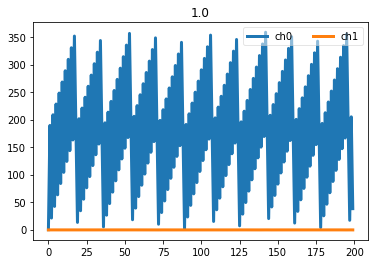

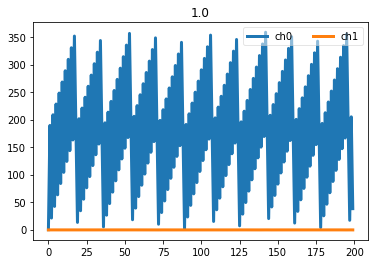

In [ ]:
show_timeseries(x0, title=y0)

In [ ]:
# create directly from x, y
x = np.random.randn(4, 5, 6)
y = np.random.randint(0, 2, size=x.shape[0])
data = TSDataChaos.from_xy(x, y, index_col=5)
data

TSDataChaos:
 Datasets names (concatenated): []
 Filenames:                     []
 Data shape: (4, 5, 6)
 Targets shape: (4,)
 Nb Samples: 4
 Nb Channels:           5
 Sequence Length: 6

### Remove uncertain orbits

In [ ]:
#export
@patch
def remove_uncertainty(self:TSDataChaos, uncertainty_index=-1):
    self.x = self.x[self.y != uncertainty_index]
    self.ds = self.ds[self.y != uncertainty_index]
    self.y = self.y[self.y != uncertainty_index]

In [ ]:
uncertainty_index = -1
fnames = (Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames)
test_eq(uncertainty_index in foo.y, True)
foo.remove_uncertainty()
test_eq(uncertainty_index in foo.y, False)

### Export chaos data to files 

In [ ]:
# export
@patch
def export(self:TSDataChaos, fname_poinc_map, fname_index):
    r"""
        Export x and y in two different files in the same format used
        to load them
    """
    # 1. data
    indices = np.arange(0.0, 2*np.pi*self.x.shape[-1], 2*np.pi)
    dfs = [pd.DataFrame(o.transpose()).set_index(indices) for o in self.x]
    with open(fname_poinc_map, 'w') as f:
        for df in dfs:
            df.to_csv(f, sep='\t', header=None, mode='a')
    # 2. indices
    with open(fname_index, 'w') as f:
        for df, y in zip(dfs, self.y):
            line_placeholder = np.concatenate(
                (df.iloc[0].values, # Initial conditions
                 [np.nan, np.nan], # TODO: What is the third and fourth column of the file?
                 np.repeat(np.nan, len(index_cols)-1) # indices
                )
            )
            line_placeholder[self.index_col] = y
            np.savetxt(f, line_placeholder[np.newaxis])

In [ ]:
base_path = Path.home()
outfile_poinc = base_path/'Poincare.plt'
outfile_index = base_path/'index.plt'
fnames = (Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames)
foo.export(outfile_poinc, outfile_index)
# reload the data and check that it is the same
out_fnames = (outfile_poinc, outfile_index)
bar = TSDataChaos.from_poincare_and_index_files((outfile_poinc, outfile_index))
test_eq(foo.x, bar.x)
test_eq(foo.y, bar.y)
# Remove the temporary output files for created for this test
outfile_poinc.unlink()
outfile_index.unlink()

## Get items from a TSDataChaos object

In [ ]:
#export
def get_motion_items(fnames):
    "get_ts_items return list of tuples. Each tuple corresponds \
    to a timeserie (nump.ndarray) and a label (string). fnames is not \
    an array of paths, but an array of tuples of paths. Each tuple has the \
    path of the Poincare map and the path of the index file"
    data = TSDataChaos.from_poincare_and_index_files(fnames)
    return data.get_items()

### Show labelled initial condition map

In [ ]:
#export
def show_labelled_ic_map(poinc_maps:Union[torch.Tensor, np.ndarray], 
                         preds:Union[torch.Tensor, np.ndarray], vocab:list=None, show_confidence=False,
                         show_legend=False, color_values=None, **kwargs):
    r"""
    Show a scatter plot with the initial conditions (x0, y0) of each Poincare map in \
    `poinc_maps`, coloured with the predictions given in `preds`.. The argument `poinc_maps` \
    expects a (n_items, n_channels, n_points) numpy array or tensor. PRedictions can
    be given as a rank-2 tensor, with the output probabilities for each class, or as a
    rank-1 tensor, with the index of the predicted class. If `show_confidence` is true,
    it will contain the probability distribution of each prediction, which will be
    used to plot each point in the map with higher or level transparency (predictions with
    higher probability will have greater values of transparency)
    """
    ic = poinc_maps[:,:,0]
    data = pd.DataFrame(ic, columns=['x0', 'y0'])
    if isinstance(preds, np.ndarray): preds = tensor(preds)
    if preds.ndim == 1: preds = F.one_hot(preds)
    lbls = torch.argmax(preds, dim=1)
    data['lbl'] = L(lbls, use_list=True).map(lambda o: vocab[o]) if vocab else L(lbls, use_list=True).map(str)
    data['confidence'] = torch.max(preds, dim=1).values
    scale_args = dict()
    if not show_legend: scale_args['guide']=False
    # Color values follow the same order of the vocab
    scale_color_layer = scale_color_discrete(**scale_args) if not color_values else scale_color_manual(color_values, **scale_args)
    
    res = (
        ggplot(data, aes('x0', 'y0')) + 
        theme_classic()
    )
    if show_confidence:
        res = (res + geom_point(aes('x0','y0', color='lbl', alpha='confidence'), 
                                shape='.') + 
        scale_color_layer + scale_alpha_continuous(**scale_args))
    else:
        res = (res + geom_point(aes('x0','y0', color='lbl'), shape='.') + 
               scale_color_layer)
    return res

In [ ]:
mock_poinc_map = np.random.randn(1000, 2, 100)
mock_preds = torch.rand(1000, 3)
mock_preds = mock_preds/mock_preds.sum(dim=1)[:, None] # Make the probs sum up 1
vocab = ['chaotic', 'librational', 'rotational']

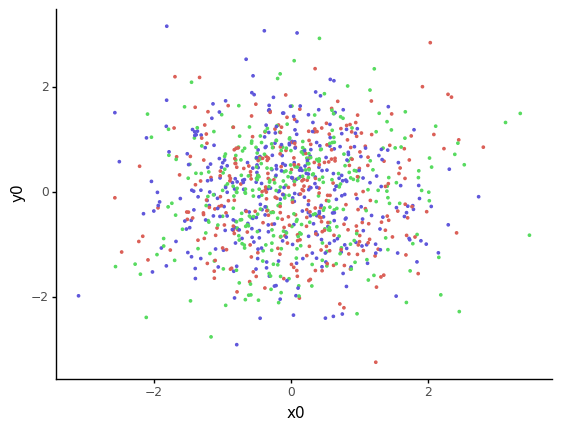

<ggplot: (8733256444121)>

In [ ]:
# NOTE: These FLI plots are completely random
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds)

Try different colors

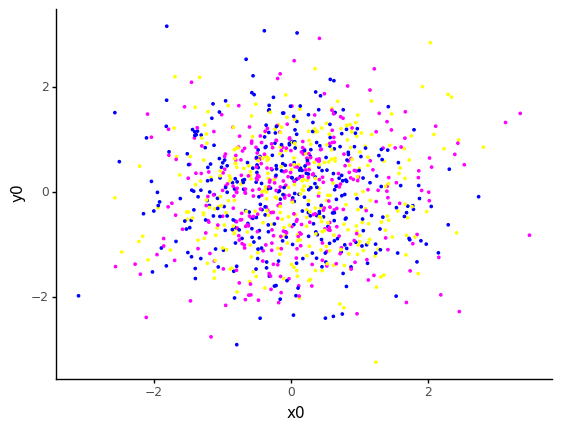

<ggplot: (8733257384325)>

In [ ]:
# NOTE: These FLI plots are completely random
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, 
                     color_values=['yellow', 'magenta', 'blue'])

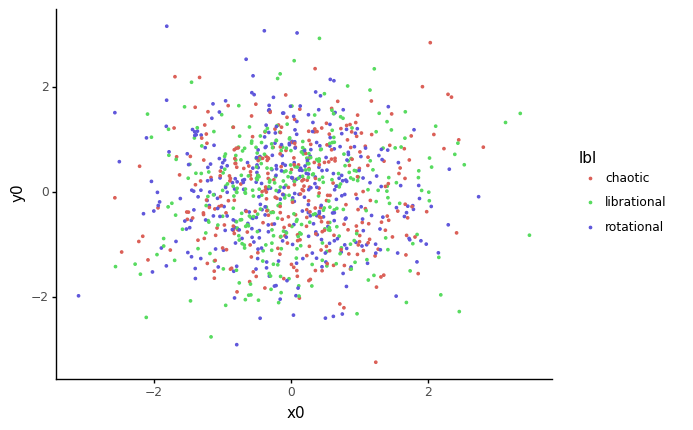

<ggplot: (8733257536913)>

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, 
                     vocab = vocab, show_legend=True)

Test the use of probs to and its visualization through point transparency

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, show_confidence=True)

TypeError: Discrete value supplied to continuous scale

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, vocab=vocab,
                     show_confidence=True, show_legend=True)

TypeError: Discrete value supplied to continuous scale

In [ ]:
# preds is a numpy array of targets
mock_preds = np.random.randint(0, 3, mock_poinc_map.shape[0])
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, vocab=vocab,
                     show_confidence=True, show_legend=True)

TypeError: Discrete value supplied to continuous scale

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
beep(1)

Converted cam.ipynb.
Converted core.ipynb.
Converted data.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
Converted motion_classification_time_series.ipynb.
Converted utils.ipynb.
